In [217]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_tree
import graphviz

ModuleNotFoundError: No module named 'graphviz'

# Load Data

In [4]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [5]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [6]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


# ListOfBs

In [7]:
#listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [8]:
#len(listOfBs)

259

In [9]:
#df_mess_train.shape

(39250, 8)

# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  


# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

df_feat, id_list_train = feat_mat_const(df_mess_train, listOfBs)
df_feat.head()

In [14]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

# Onehot

In [45]:
bsid = pd.get_dummies(df_mess_train['bsid'],prefix='bsid')
rssi = pd.get_dummies(df_mess_train['bsid'],prefix='rssi').multiply(df_mess_train["rssi"], axis="index")
time_ux = pd.get_dummies(df_mess_train['bsid'],prefix='time').multiply(df_mess_train["time_ux"], axis="index")
bs_lat = pd.get_dummies(df_mess_train['bsid'],prefix='blat').multiply(df_mess_train["bs_lat"], axis="index")
bs_lng = pd.get_dummies(df_mess_train['bsid'],prefix='blng').multiply(df_mess_train["bs_lng"], axis="index")

In [122]:
df_train = df_mess_train.drop(['bsid', 'did', 'nseq', 'rssi', 'time_ux', 'bs_lat', 'bs_lng'], axis=1)
df_train = df_train.join(bsid).join(rssi).join(time_ux).join(bs_lat).join(bs_lng)

In [125]:
df_train

,messid,bsid_879,bsid_911,bsid_921,bsid_944,bsid_980,bsid_1012,bsid_1086,bsid_1092,bsid_1120,...,blng_8747,blng_9784,blng_9899,blng_10134,blng_10148,blng_10151,blng_10162,blng_10999,blng_11007,blng_11951
0,573bf1d9864fce1a9af8c5c9,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
1,573bf1d9864fce1a9af8c5c9,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,573bf3533e952e19126b256a,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
3,573c0cd0f0fe6e735a699b93,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4,573c0cd0f0fe6e735a699b93,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39245,5848672e12f14360d7942374,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
39246,5848672e12f14360d7942374,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
39247,5848672e12f14360d7942374,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
39248,58487473e541cd0e133cca72,0,0,0,0,0,0,0,0,0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [126]:
df_train = df_train.groupby('messid').sum()

In [127]:
df_train

,bsid_879,bsid_911,bsid_921,bsid_944,bsid_980,bsid_1012,bsid_1086,bsid_1092,bsid_1120,bsid_1148,...,blng_8747,blng_9784,blng_9899,blng_10134,blng_10148,blng_10151,blng_10162,blng_10999,blng_11007,blng_11951
messid,,,,,,,,,,,,,,,,,,,,,
573bf1d9864fce1a9af8c5c9,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573bf3533e952e19126b256a,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c0cd0f0fe6e735a699b93,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c1272f0fe6e735a6cb8bd,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
573c8ea8864fce1a9a5fbf7a,0,0,0,0,0,0,1,0,0,0,...,0.0,0.0,-105.026605,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848551912f14360d786ede6,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485a25e541cd0e1329b8d6,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58485bd412f14360d78bebdb,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,-105.026605,0.0,0.0,-68.5,0.0,0.0,-68.5,0.0


# formating

In [128]:
# Feature Matrix construction 

#def feat_mat_const(df_mess_train, listOfBs):
#    train = pd.concat([df_mess_train, pos_train], axis=1, sort=False)
#    trainid = train.drop_duplicates(subset = "messid", keep = False, inplace = False)[["messid", "lat", "lng"]]
#    return df_feat

# ground truth construction

Real lat and lng for train data

In [108]:
ground_truth = pd.concat([df_mess_train, pos_train], axis=1, sort=False).drop_duplicates(subset = "messid", keep = 'first')[["messid", "lat", "lng"]]
ground_truth_lat = ground_truth.lat
ground_truth_lng = ground_truth.lng

# Use Cross Validation to test models

## Random Forest

In [135]:
clf_lat = RandomForestRegressor(n_estimators = 55)
clf_lng = RandomForestRegressor(n_estimators = 55)

pred_lat_clf = cross_val_predict(clf_lng, df_train, ground_truth_lat, cv=10)
pred_lng_clf = cross_val_predict(clf_lat, df_train, ground_truth_lng, cv=10)

## Linear Regression

In [167]:
reg_lat = linear_model.LinearRegression()
reg_lng = linear_model.LinearRegression()

pred_lat_reg = cross_val_predict(clf_lat, df_train, ground_truth_lat, cv=10)
pred_lng_reg = cross_val_predict(clf_lng, df_train, ground_truth_lng, cv=10)

## XGBoost

booster = gbtree, gblinear or dart.

In [232]:
reg_lat = xgb.XGBRegressor()

reg_lng = xgb.XGBRegressor()

pred_lat_xgb = cross_val_predict(reg_lat, df_train, ground_truth_lat, cv=10)
pred_lng_xgb = cross_val_predict(reg_lng, df_train, ground_truth_lng, cv=10)

[15:32:01] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:23] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:45] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:06] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:30] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:52] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is n

# Evaluate result

In [61]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [62]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [233]:
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, pred_lat_xgb, pred_lng_xgb)

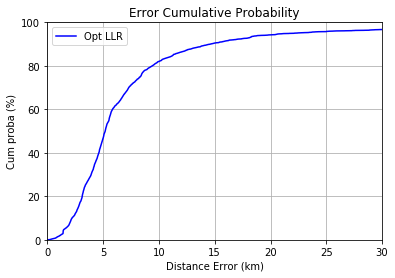

In [234]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [231]:
# Error criterion
np.percentile(err_vec, 80)

6762.588946332104